In [1]:
import math, time 
import matplotlib.pyplot as plt
import numpy as np 
import pandas as pd
import seaborn as sns
start = time.time()
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, roc_auc_score
from imblearn.datasets import make_imbalance
# from keras.utils import to_categorical
# import keras


In [ ]:
imbalance = False
add_noise = False
noise_ratio = 20
asym_noise = False

In [2]:
mnist_dataset = fetch_openml('mnist_784', version=1, as_frame=True)
# mnist_dataframe = pd.read_csv('/Users/shriramr/OneDrive - University at Buffalo/First Semester/Pattern Recognition/Demo Code/Extras/mnist_train_small.csv', sep=',', index_col=0)
#print mnist_dataframe.head(3)
# print(mnist_dataframe.shape)

In [3]:
mnist_dataframe = pd.DataFrame(data= np.c_[mnist_dataset['data'], mnist_dataset['target']],
                     columns= mnist_dataset['feature_names'] + ['target'])

In [4]:
print(mnist_dataframe.shape)

(70000, 785)


In [5]:
def noise_helper(n_classes, current_class):
    if current_class < 0 or current_class >= n_classes:
        error_str = "class_ind must be within the range (0, nb_classes - 1)"
        raise ValueError(error_str)

    other_class_list = list(range(n_classes))
    other_class_list.remove(current_class)
    other_class = np.random.choice(other_class_list)
    return other_class

def create_noise(y_tr, noise_ratio, asym = False):
    if noise_ratio > 0:
        dataset = 'mnist'
        print(y_tr)
        noisy_y_tr = np.array(y_tr, copy=True)
        if asym:
            if dataset == 'mnist':
                # 1 < - 5, 2 -> 4, 3 -> 7, 5 <-> 6, 8 -> 9
                source_class = [5, 2, 3, 5, 6, 8]
                target_class = [1, 4, 7, 6, 5, 9]
            if dataset == 'mnist' :
                for s, t in zip(source_class, target_class):
                    cls_idx = np.where(y_tr == s)[0]
                    n_noisy = int(noise_ratio * cls_idx.shape[0] / 100)
                    noisy_sample_index = np.random.choice(cls_idx, n_noisy, replace=False)
                    noisy_y_tr[noisy_sample_index] = t
        else:
            n_samples = noisy_y_tr.shape[0]
            n_noisy = int(noise_ratio * n_samples / 100)
            class_index = [np.where(y_tr == i)[0] for i in range(10)]
            class_noisy = int(n_noisy / 10)

            noisy_idx = []
            for d in range(10):
                noisy_class_index = np.random.choice(class_index[d], class_noisy, replace=False)
                noisy_idx.extend(noisy_class_index)

            for i in noisy_idx:
                noisy_y_tr[i] = noise_helper(n_classes=10, current_class=y_tr[i])

        print("Print noisy label generation statistics:")
        count = 0
        for i in range(10):
                n_noisy = np.sum(noisy_y_tr == i)
                print("Noisy class %s, has %s samples." % (i, n_noisy))
                count += n_noisy
        print(count)
        return noisy_y_tr

/Users/shriramr/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


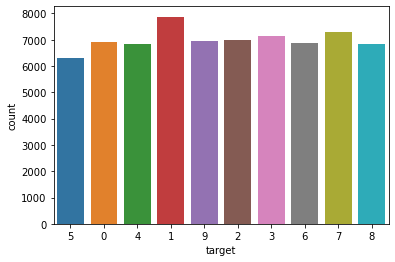

1    7877
7    7293
3    7141
2    6990
9    6958
0    6903
6    6876
8    6825
4    6824
5    6313
Name: target, dtype: int64


pandas.core.series.Series

In [26]:
sns.countplot(mnist_dataframe['target'])
plt.show()# looks kinda okay
# or we can just print
print(mnist_dataframe['target'].value_counts())
type(mnist_dataframe['target'])

In [39]:
steps = [('scaler', StandardScaler()), ('SVM', SVC(kernel='poly'))]
parameters = {'SVM__C':[0.001], 'SVM__gamma':[10]}
pipeline = Pipeline(steps) # define Pipeline object

Pure dataset


/Users/shriramr/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


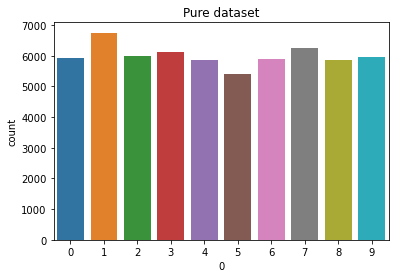

1    6752
7    6251
3    6121
2    5991
9    5964
0    5917
6    5894
8    5850
4    5849
5    5411
dtype: int64
Dataset after imbalance


/Users/shriramr/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


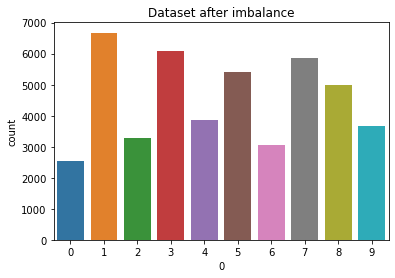

1    6675
3    6100
7    5860
5    5400
8    5000
4    3850
9    3654
2    3280
6    3065
0    2550
dtype: int64


In [50]:
X_tr = mnist_dataframe.iloc[:,:-1] # iloc ensures X_tr will be a dataframe
y_tr = mnist_dataframe.iloc[:, -1]
X_train, X_test, y_train, y_test = train_test_split(X_tr, y_tr, test_size=10000, stratify=y_tr)
targets_np = np.array(y_train, dtype=np.int64)
data_np = np.array(X_train, dtype=np.float64)
classes = np.unique(targets_np)

print("Pure dataset")
test_tuple = pd.DataFrame(targets_np)
sns.countplot(test_tuple[0])
plt.title("Pure dataset")
plt.show()
print(test_tuple.value_counts())

if imbalance:
    data_np = data_np.reshape(-1,784,)
    X_train, y_train = make_imbalance(data_np, targets_np,
                                sampling_strategy={0: 2550, 1: 6675, 2: 3280, 3: 6100, 4: 3850, 5: 5400, 6: 3065, 7: 5860, 8: 5000, 9: 3654,},
                                random_state=42)
    targets_np = np.array(y_train, dtype=np.int64)                    
    print("Dataset after imbalance")
    test_tuple = pd.DataFrame(targets_np)
    sns.countplot(test_tuple[0])
    plt.title("Dataset after imbalance")
    plt.show()
    print(test_tuple.value_counts())

if add_noise:
    y_train = create_noise(y_tr=targets_np, noise_ratio=noise_ratio, asym=asym_noise)
    targets_np = np.array(y_train, dtype=np.int64)
    print("Dataset after adding noise")
    test_tuple = pd.DataFrame(targets_np)
    sns.countplot(test_tuple[0])
    plt.title("Dataset after adding noise")
    plt.show()
    print(test_tuple.value_counts())

# X_train = X_train[:40000]
# y_train = y_train[:40000]


In [ ]:
grid = GridSearchCV(pipeline, param_grid=parameters, cv=5)
grid.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('SVM', SVC(kernel='poly'))]),
             param_grid={'SVM__C': [0.001], 'SVM__gamma': [10]})

In [ ]:
print("Score = %3.2f"%(grid.score(X_test, y_test)))

Score = 0.88


In [ ]:
print("best parameters from train data: ", grid.best_params_)

best parameters from train data:  {'SVM__C': 0.001, 'SVM__gamma': 10}


In [ ]:
y_pred = grid.predict(X_test)

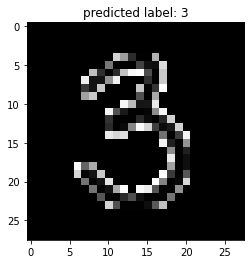

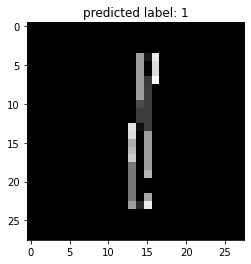

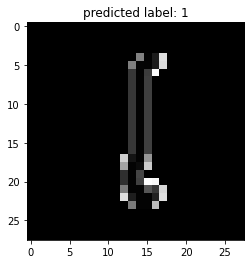

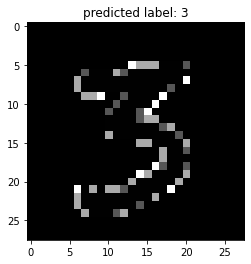

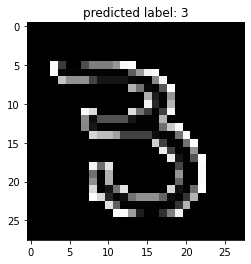

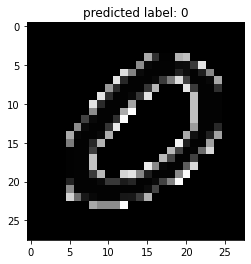

In [ ]:
for i in (np.random.randint(0,270,6)):
	two_d = (np.reshape(X_test.values[i], (28, 28)) * 255).astype(np.uint8)
	plt.title('predicted label: {0}'. format(y_pred[i]))
	plt.imshow(two_d, interpolation='nearest', cmap='gray')
	plt.show()

In [ ]:
y_test = np.int32(y_test)
y_pred = np.int32(y_pred)
print("confusion matrix: \n ", confusion_matrix(y_test, y_pred))
# print(y_test)
# print(y_pred)
print("Accuracy of the balanced dataset with symmetric noise is \n", accuracy_score(y_test, y_pred))
print("Precision of the balanced dataset with symmetric noise is \n", precision_score(y_test, y_pred, average = None))
print("Recall of the balanced dataset with symmetric noise is ", recall_score(y_test, y_pred, average = None))
cat_ypred = to_categorical(y_pred, 10)
print("ROC AUC score of the balanced dataset with symmetric noise is \n", roc_auc_score(y_test, cat_ypred, multi_class='ovr'))

confusion matrix: 
  [[ 966    2    0    4    0    3    3    1    7    0]
 [   0 1115    3    1    0    1    0    2    3    0]
 [   5    4  963    2    4    3    3    8    7    0]
 [   0    0    2  994    0    8    0    6   10    0]
 [   2    2    2    0  956    3    6    3    1    0]
 [   1    0    4    7    0  886    2    0    2    0]
 [   1    2    1    2    4    8  960    1    3    0]
 [   0    4    3    0    3    0    0 1030    2    0]
 [   3    2    5    6    3   10    0    3  943    0]
 [   5    2    9   37  521   10    1  382   27    0]]
Accuracy of the balanced dataset with symmetric noise is 
 0.8813
Precision of the balanced dataset with symmetric noise is 
 [0.982706   0.98411297 0.97076613 0.94396961 0.64118042 0.95064378
 0.98461538 0.71727019 0.93830846 0.        ]
Recall of the balanced dataset with symmetric noise is  [0.97971602 0.99111111 0.96396396 0.9745098  0.98051282 0.98226164
 0.97759674 0.98848369 0.96717949 0.        ]


/Users/shriramr/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


NameError: name 'to_categorical' is not defined